In [22]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

# Replace this to use Noisy QLSTM
# from QLSTM_Noisy import SequenceDataset
from QLSTM import SequenceDataset

In [23]:
df  = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


In [24]:
#df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')

In [25]:
df.columns

Index(['Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'OccRate'], dtype='object')

In [26]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     8064 non-null   object 
 1   ToVol    8064 non-null   int64  
 2   SmVol    8064 non-null   int64  
 3   MeVol    8064 non-null   int64  
 4   LaVol    8064 non-null   int64  
 5   Speed    8064 non-null   float64
 6   OccRate  8064 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 441.1+ KB


In [28]:
df=df[:144]

교통량을 예측해보자. 
- 속도, 점유율 이용하자

In [29]:
columns = ['SmVol', 'ToVol', 'Speed', 'OccRate']

In [30]:
data = df[columns]
data.head()

,SmVol,ToVol,Speed,OccRate
0,34,43,50.3,1.90
1,32,45,58.9,1.84
2,34,46,50.6,1.87
3,36,45,50.9,1.72
4,13,27,62.2,1.12


In [31]:
data.tail()

,SmVol,ToVol,Speed,OccRate
139,85,118,51.8,4.96
140,81,117,47.5,5.08
141,87,137,48.3,6.00
142,80,118,50.6,4.67
143,105,153,46.7,6.65


In [32]:
dataset = data.values

In [33]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [34]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'ToVol'

In [35]:
features

Index(['SmVol', 'ToVol', 'Speed', 'OccRate'], dtype='object')

In [36]:
target

'ToVol'

In [37]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [38]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [39]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [40]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [41]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [42]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 292


In [43]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 5 # 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.05965336070461831
Test loss: 0.94945415972986
Execution time 157.93482613563538
Epoch 1
---------
Train loss: 0.017361271776145486
Test loss: 0.6172414578911375
Execution time 156.6946258544922
Epoch 2
---------
Train loss: 0.00228202861630173
Test loss: 0.572921623295935
Execution time 159.2624204158783
Epoch 3
---------
Train loss: 0.002939157792648075
Test loss: 0.5503184352485484
Execution time 214.30889701843262
Epoch 4
---------
Train loss: 0.0011569447545914447
Test loss: 0.5769733958719702
Execution time 203.86562633514404


In [44]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

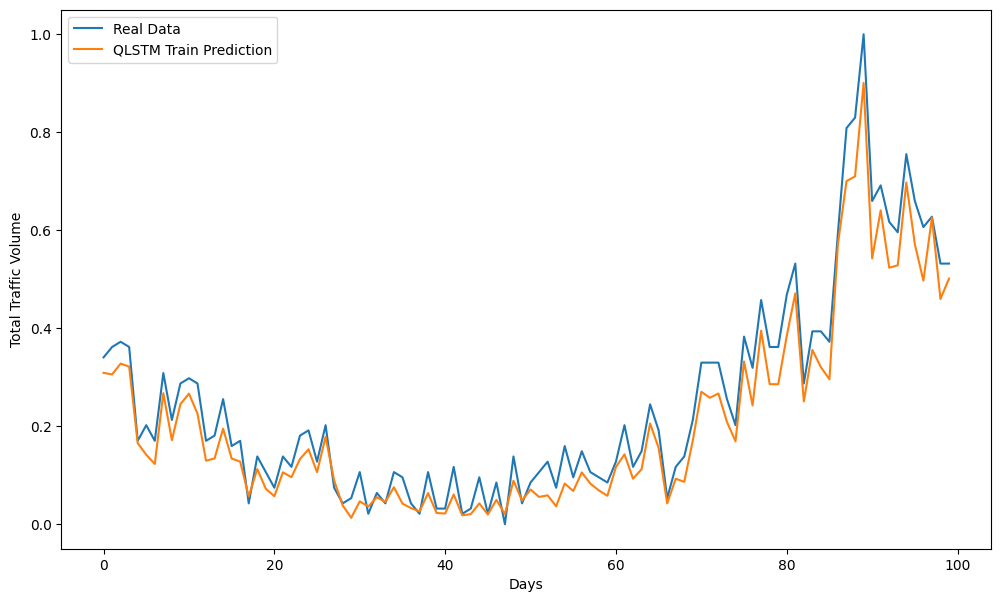

In [51]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["ToVol"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Total Traffic Volume')
plt.xlabel('Days')
plt.legend()
plt.show()

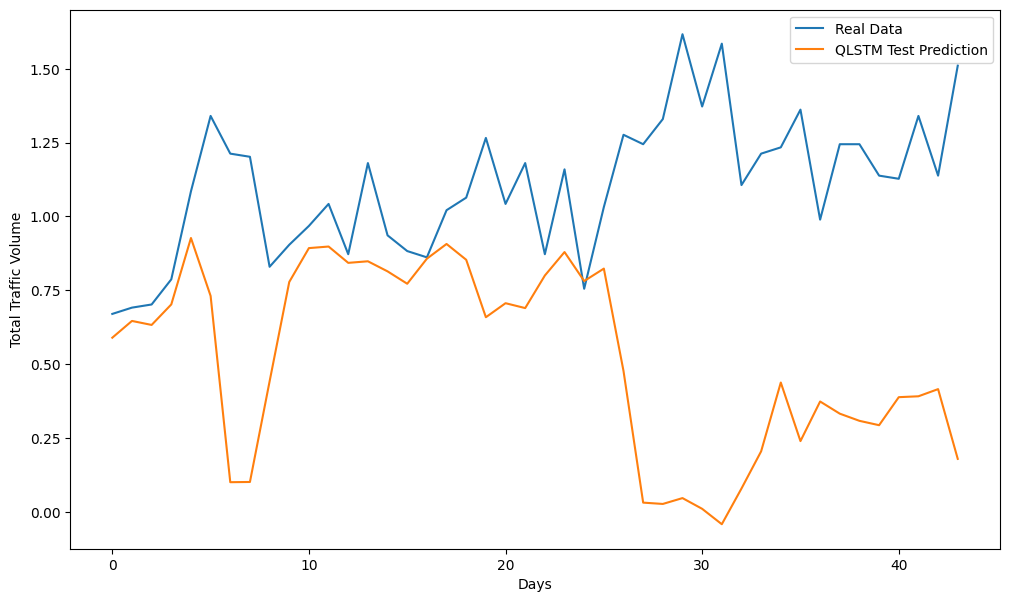

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["ToVol"], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "QLSTM Test Prediction")
plt.ylabel('Total Traffic Volume')
plt.xlabel('Days')
plt.legend() 
plt.show()

In [53]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train["ToVol"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["ToVol"], df_test["Model Forecast"]))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.0506846729788743
Test RMSE: 0.7595876533587823


In [54]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["ToVol"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["ToVol"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.96
Test accuracy: 0.20454545454545456


In [ ]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")